# <center>Forecasting Beer Demand using Seasonal ARIMA model </center>


### About this Notebook
In this notebook, I will be implementing the Seasonal ARIMA model on a non stationary time series data. The dataset can be downloaded using this [link](https://www.kaggle.com/sergiomora823/monthly-beer-production).

For a quick overview on the concept of Seasonal ARIMA model watch [this](https://youtu.be/WjeGUs6mzXg) video

### Importing Required packages

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Lets read in the data
df = pd.read_csv("beer.csv")
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


As we can see, it is a very simple dataframe with monthly beer production values from January 1956

In [3]:
#lets look at the brief summary of the Dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [4]:
df['Month']=pd.to_datetime(df['Month'])

In [5]:
df.dtypes

Month                      datetime64[ns]
Monthly beer production           float64
dtype: object

In [6]:
# Lets set the month column as the index for our Dataframe
df.set_index('Month',inplace=True)

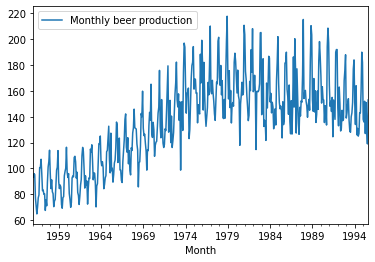

In [7]:
# Basic plot to get the general idea of the trends in data
df.plot()

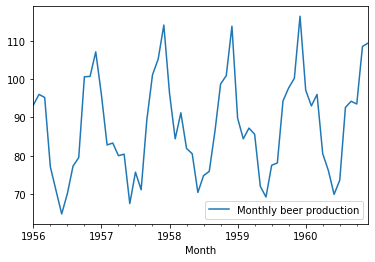

In [8]:
df.iloc[:60].plot()

#### When we look closely into our data,we can clearly see that there is some annual seasonality

### Selecting appropriate Model:
To continue with out time series analysis, we must first test for stationarity
For this, let's use Dickey–Fuller test 

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
test=adfuller(df['Monthly beer production'])
print (test)

(-2.282661418787579, 0.17762099829132444, 17, 458, {'1%': -3.4447087976702284, '5%': -2.867871300049488, '10%': -2.5701423432047443}, 3463.9034375936567)



## Note:
Running adfuller on the beer production column returns the following values in order : (ADF Test Statistic, p-value, No. of Lags Used, No. of Observations Used,{Critical Values},icbest)

The adfuller test returned a p-value of 0.178. We can assume that the data is stationary only if the p-value is very low (less than 0.05). To acheive stationarity, lets difference the production data by twelve months and check the p-value using the adfuller test

In [12]:
annual_difference = df['Monthly beer production'] - df['Monthly beer production'].shift(12)
adfuller(annual_difference.dropna())

(-2.8967624777520093,
 0.045725774623596185,
 17,
 446,
 {'1%': -3.4450973903602367, '5%': -2.868042229965336, '10%': -2.570233448893},
 3363.9055003775306)

As suspected,some annual seasonality is present since the p-value has reduced below 0.05 for 12 months difference. Hence we can assume stationarity when differencing by 12 months

In [13]:
df['Annual Difference']=annual_difference

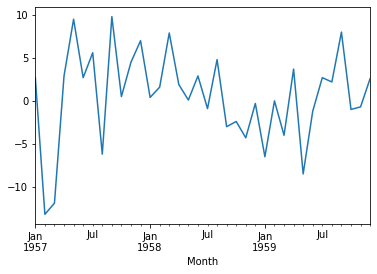

In [14]:
(df['Annual Difference'].iloc[12:48]).plot()

In [15]:
df.head()

,Monthly beer production,Annual Difference
Month,,
1956-01-01,93.2,NaN
1956-02-01,96.0,NaN
1956-03-01,95.2,NaN
1956-04-01,77.1,NaN
1956-05-01,70.9,NaN


### Since the data is non stationary, SARIMA model will be suitable to predict this data
#### Seasonal ARIMA MODEL  (Auto Regressive Integrated Moving Average) :
* AutoRegression(p) : A model that accounts for the relationship between an observation and n number of lagged observations
* Integrated(d) : The use of differencing of observations to achieve stationarity
* Moving Average(q) : A model that accounts for the linear dependancy of output variable on the current and various past values

#### For applying the ARIMA model we need p,q and q values:
* p is the AR model lags and can be determined from the pacf plot
* d is the degree of differencing
* q is the size of the moving average window (order)

In [16]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

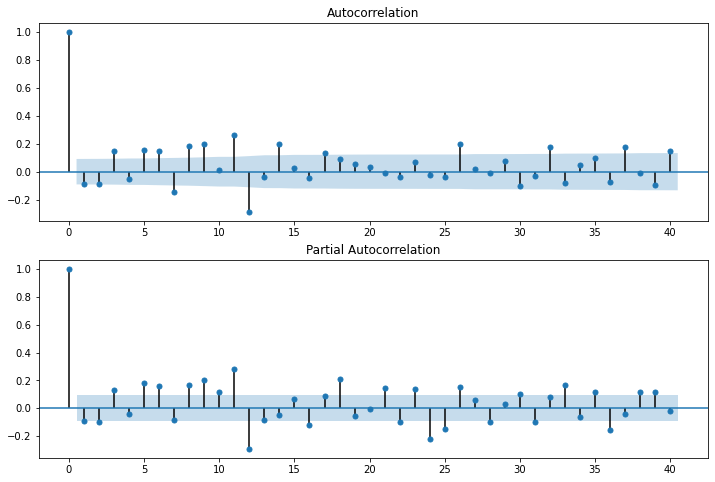

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Annual Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Annual Difference'].iloc[13:],lags=40,ax=ax2)

* For an AR model, the theoretical PACF “shuts off” past the order(p) of the model
* For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an   MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

Since our data is not an ideal case of the ARIMA model, the trend is not clearly visible. 
We will take p,d,q values as (1,1,1) and seasonal factor as 12 (for SARIMA model)
To learn more on selecting p,d,q values from the autocorrelation charts refer to this [paper](https://online.stat.psu.edu/stat510/book/export/html/662)

In [18]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
x_test=df['Monthly beer production'].iloc[:400]

In [20]:
# Create Model with first 400 values and use it to predict the remaining values inorder to check accuracy
model=ARIMA(x_test,order=(1,1,1))
model_fit=model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


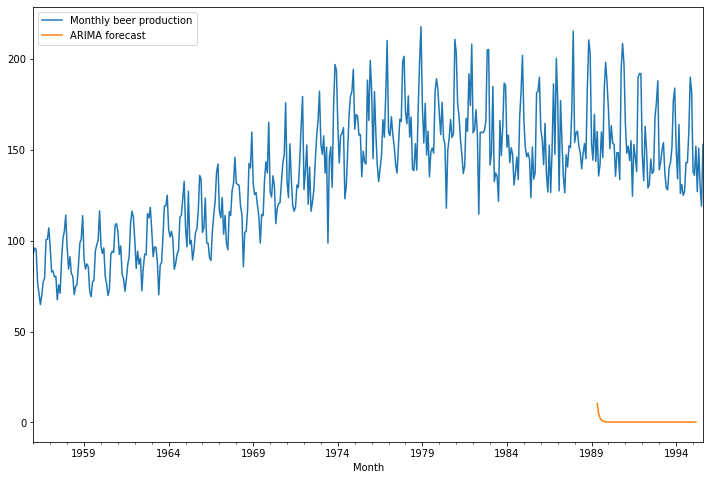

In [21]:
df['ARIMA forecast']=model_fit.predict(start=400,end=470,dynamic=True)
df[['Monthly beer production','ARIMA forecast']].plot(figsize=(12,8))

As expected the ARIMA model did not return a good prediction since the model does not account for seasonality. So lets implement Seasonal ARIMA model

In [22]:
model=sm.tsa.statespace.SARIMAX(x_test,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


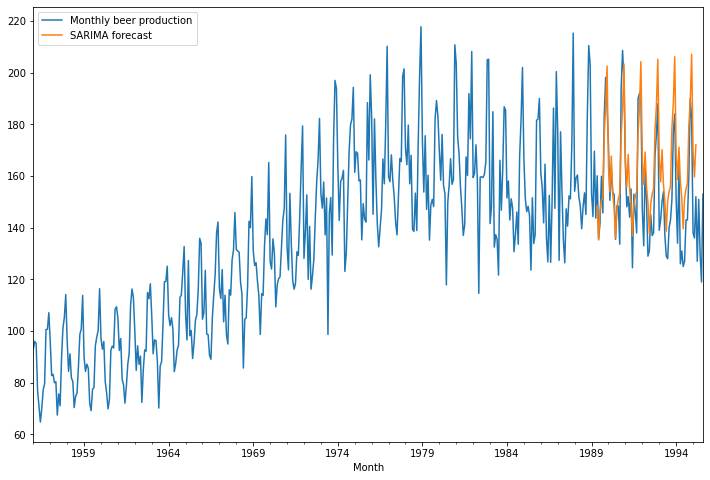

In [23]:
df['SARIMA forecast']=results.predict(start=400,end=470,dynamic=True)
df[['Monthly beer production','SARIMA forecast']].plot(figsize=(12,8))

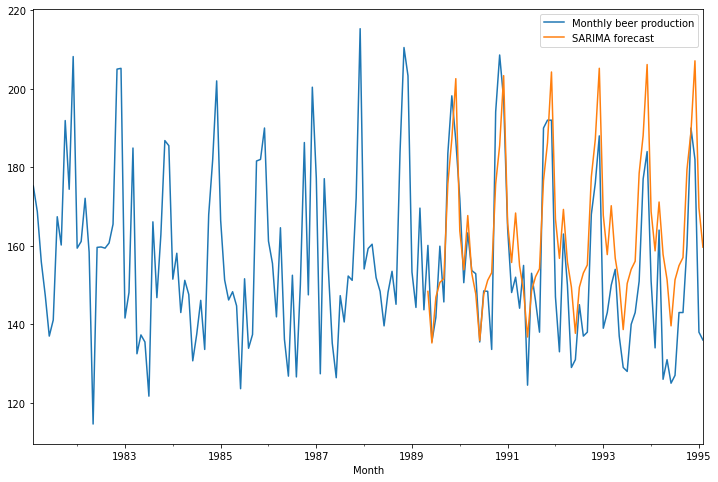

In [24]:
df[['Monthly beer production','SARIMA forecast']].iloc[301:470].plot(figsize=(12,8))

From visual analysis, we can see that the SARIMA model performed reasonably well. However, to understand the accuracy of the model mathematically, we can calculate the residual and find the mean absolute percent error and root mean squared error.

In [25]:
residuals=df['Monthly beer production']-df['SARIMA forecast']
residuals.dropna(inplace=True)

In [26]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/df['Monthly beer production'].iloc[400:471])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0869
Root Mean Squared Error: 15.258221163109098


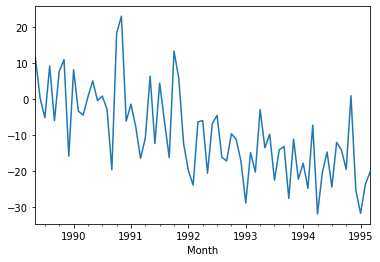

In [27]:
residuals.plot()

Now, lets forecast values for the next two years

In [28]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [29]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [30]:
future_df=pd.concat([df,future_datest_df])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2012: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


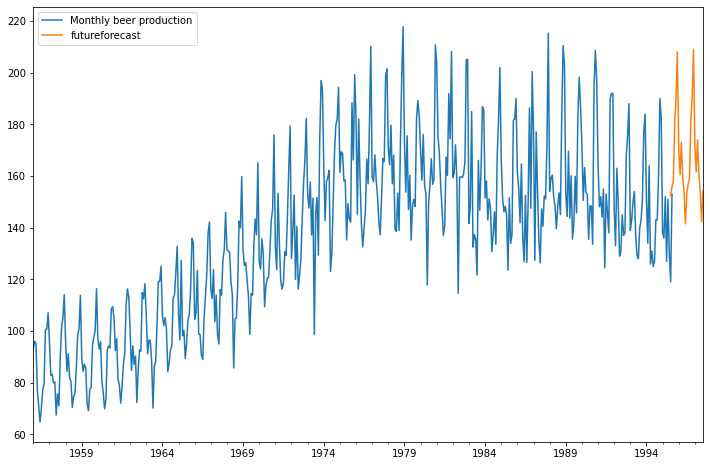

In [31]:
future_df['futureforecast'] = results.predict(start = 474, end = 500, dynamic= True)  
future_df[['Monthly beer production', 'futureforecast']].plot(figsize=(12, 8))

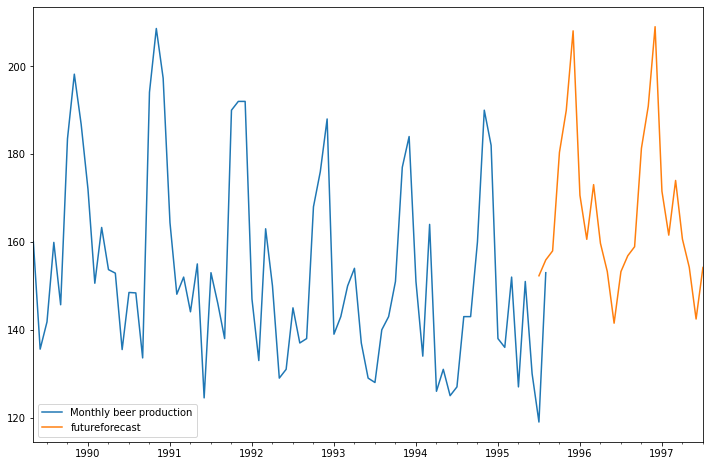

In [32]:
future_df[['Monthly beer production', 'futureforecast']].iloc[400:].plot(figsize=(12, 8))